<a href="https://colab.research.google.com/github/wangdedi1997/Disentanglement-Beta-FactorVAE/blob/master/SPIB_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPIB Demo 2021
This notebook aims to serve as a simple introduction to the state predictive information bottleneck method of [Wang and Tiwary 2021](https://aip.scitation.org/doi/abs/10.1063/5.0038198). The code is implemented using Pytorch.

<img src="https://github.com/tiwarylab/State-Predictive-Information-Bottleneck/blob/main/fig/Fig_alg.png?raw=1">

<img src="https://github.com/tiwarylab/State-Predictive-Information-Bottleneck/blob/main/fig/Fig_FW_example.png?raw=1">

## Clone the Github to Colab

In [1]:
!git clone https://github.com/tiwarylab/State-Predictive-Information-Bottleneck

Cloning into 'State-Predictive-Information-Bottleneck'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 117 (delta 66), reused 49 (delta 20), pack-reused 0
Receiving objects: 100% (117/117), 5.22 MiB | 9.32 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [2]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = [25, 20]
np.random.seed(42)

In [3]:
large = 54; med = 36; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'legend.title_fontsize':large,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

## Data Preparation
The trajectory data can be generated from the molecular dynamics simulation or experiements. Here, we use a sample trajectory generated from Langevin dynamics simulation of a four-well analytical potential.

In [4]:
# Load trajectory data
traj_data = np.load("State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_traj_data.npy")

### Visualization of the trajectory

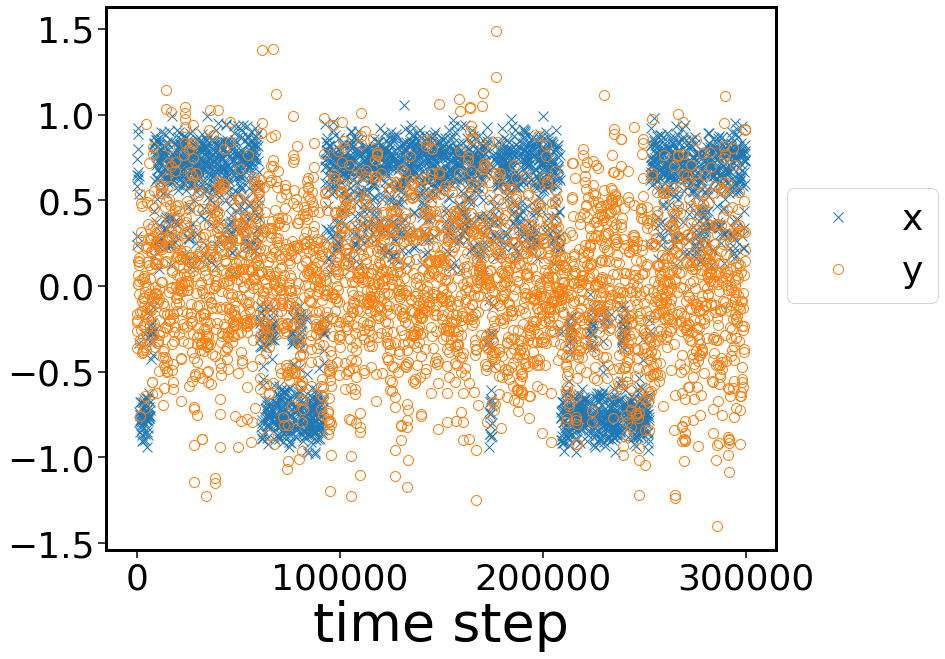

In [5]:
fig, ax = plt.subplots(figsize=(12,10))

t = np.arange(traj_data.shape[0])
ax.plot(t[::100],traj_data[::100,0],'x',label='x')
ax.plot(t[::100],traj_data[::100,1],'o',fillstyle='none',label='y')
ax.set_xlabel('time step')
ax.legend(fontsize=36,bbox_to_anchor=(0.99, 0.7))

In [6]:
# The four-well analytical potential along x
def potential_fn_FW(x):
    A=0.6
    a=80
    B=0.2
    b=80
    C=0.5
    c=40
    return 2*(x**8+A*np.exp(-a*x**2)+B*np.exp(-b*(x-0.5)**2)+C*np.exp(-c*(x+0.5)**2))+(x**2-1)**2

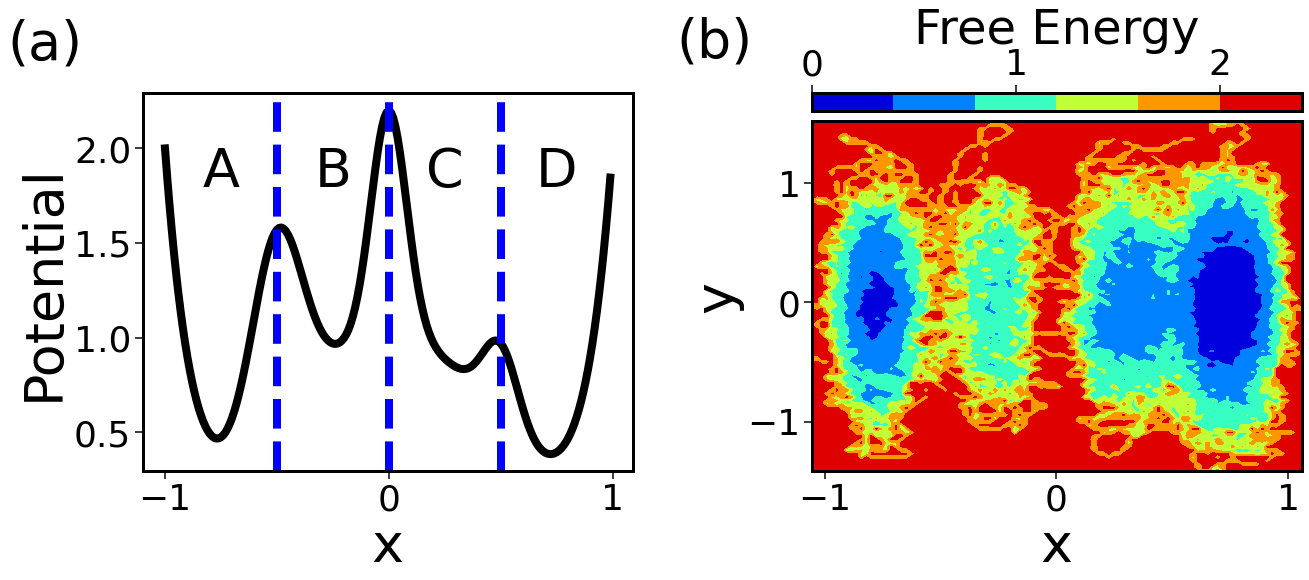

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,2,figsize=(18,8))

beta=3
lw=8

x=np.arange(-1,1,0.01)
v=potential_fn_FW(x)
ax[0].plot(x,v,color='k',lw=lw)
ax[0].axvline(x=0,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=-0.5,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=0.5,color='b',linestyle='--',lw=lw)
ax[0].text(-0.75, 1.8, 'A', horizontalalignment='center',fontsize=54)
ax[0].text(-0.25, 1.8, 'B', horizontalalignment='center', fontsize=54)
ax[0].text(0.25, 1.8, 'C', horizontalalignment='center',fontsize=54)
ax[0].text(0.75, 1.8, 'D', horizontalalignment='center', fontsize=54)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Potential")

ax[0].text(-0.2, 1.2, '(a)', horizontalalignment='center',
             transform=ax[0].transAxes,fontsize=54, va='top')

FW_counts,FW_xbins,FW_ybins,images = plt.hist2d(traj_data[:,0],traj_data[:,1],bins=100)
FW_counts[FW_counts==0]=FW_counts[FW_counts!=0].min()
FW_G=-np.log(FW_counts)/beta
FW_G=FW_G-np.nanmin(FW_G)

h0=ax[1].contourf(FW_G.transpose(),levels=5,extent=[FW_xbins[0],FW_xbins[-1],FW_ybins[0],FW_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,FW_G.max(),1)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label('Free Energy',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax[1].set_xlabel("x")
ax[1].set_ylabel('y')


ax[1].text(-0.2, 1.3, '(b)', horizontalalignment='center',
             transform=ax[1].transAxes,fontsize=54, va='top')

plt.tight_layout(pad=0.4, w_pad=5, h_pad=3.0)

### Generation of initial state labels

In [8]:
# discretize the system along x to 10 states as initial state labels
index=0

x_max=traj_data[:,index].max()+0.01
x_min=traj_data[:,index].min()-0.01

state_num=10
eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

init_label=np.zeros((traj_data.shape[0],state_num))

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

for j in range(state_num):
    indices=(traj_data[:,index]>x_list[j])&(traj_data[:,index]<=x_list[j+1])
    init_label[indices,j]=1

np.save('State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_init_label10.npy',init_label)

In [9]:
# plot the initial state labels for four well potential system
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=init_label

fig0, ax0 = plt.subplots(figsize=(9,6))
hist=ax0.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.shape[1]
state_labels=np.arange(state_num)

x_max=np.max(data[:,0])
x_min=np.min(data[:,0])

eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=ax0.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=labels[:,i])[0]
    
init_label_map=np.argmax(hist_state,axis=0).astype(float)
init_label_map[hist[0]==0]=np.nan
plt.close(fig0)

Text(0, 0.5, 'y')

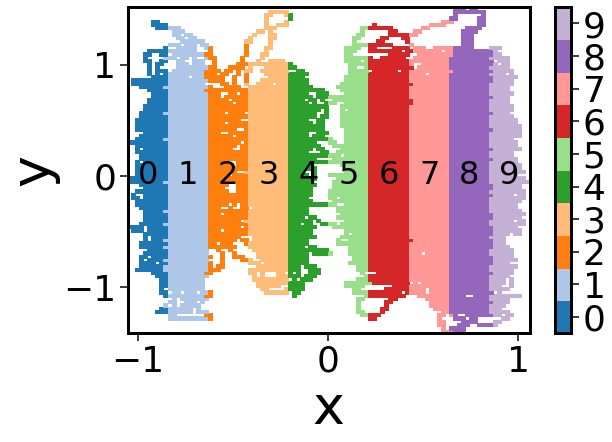

In [10]:
fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], init_label_map.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

for i in range(state_num):
    ax.text((x_list[i]+x_list[i+1])/2,0,state_labels[i],horizontalalignment='center',verticalalignment='center',fontsize=32)
    
plt.xlabel("x")
plt.ylabel("y")

## Model
We provide two ways to run SPIB: test_model.py and test_model_advanced.py. Here, we will only discuss the use of test_model.py. But for advanced analyses, we will strongly recommend to use test_model_advanced.py as it provides more features to help you to control the training process and tune the hyper-parameters. 

## Training

In [11]:
%run State-Predictive-Information-Bottleneck/test_model.py -dt 50 -d 1 -encoder_type Nonlinear -bs 512 -threshold 0.01 -patience 2 -refinements 8 -lr 0.001 -b 0.01 -seed 0 -label State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_init_label10.npy -traj State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_traj_data.npy

Iteration 500:	Time 1.699608 s
Loss (train) 1.011449	KL loss (train): 2.238273
Reconstruction loss (train) 0.989066
Loss (test) 1.096539	KL loss (test): 2.298395
Reconstruction loss (test) 1.073555
tensor([0.0000, 0.2379, 0.0000, 0.0477, 0.0000, 0.0000, 0.1356, 0.0000, 0.5788,
        0.0000])
State population change=0.259978
Epoch: 1

Iteration 1000:	Time 3.551577 s
Loss (train) 1.019712	KL loss (train): 2.115034
Reconstruction loss (train) 0.998562
Loss (test) 0.967001	KL loss (test): 2.085638
Reconstruction loss (test) 0.946144
tensor([0.0000, 0.2279, 0.0000, 0.0579, 0.0000, 0.0000, 0.1550, 0.0000, 0.5593,
        0.0000])
State population change=0.031010
Epoch: 2

Iteration 1500:	Time 5.397840 s
Loss (train) 0.921418	KL loss (train): 2.002204
Reconstruction loss (train) 0.901396
Loss (test) 0.965281	KL loss (test): 2.206697
Reconstruction loss (test) 0.943214
tensor([0.0000, 0.2276, 0.0000, 0.0581, 0.0000, 0.0000, 0.1615, 0.0000, 0.5528,
        0.0000])
State population change=0.0

<Figure size 1152x720 with 0 Axes>

## Result Analysis

In [14]:
prefix='SPIB/Unweighted_d=1_t=50_b=0.0100_learn=0.001000'
repeat='0'

In [15]:
# load the results
# the deterministic part of RC leanred by SPIB (the mean of output gaussian distrition of the encoder)
traj_mean_rep=np.load(prefix+"_traj0_mean_representation"+repeat+".npy")
# the final state labels leanred by SPIB
traj_labels=np.load(prefix+"_traj0_labels"+repeat+".npy")

In [16]:
# plot the learned state labels for four well potential system
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=traj_labels
hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.shape[1]
state_labels=np.arange(state_num)

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=labels[:,i])[0]
    
label_map50=np.argmax(hist_state,axis=0).astype(float)
label_map50[hist[0]==0]=np.nan

plt.close()

Text(0, 0.5, 'y')

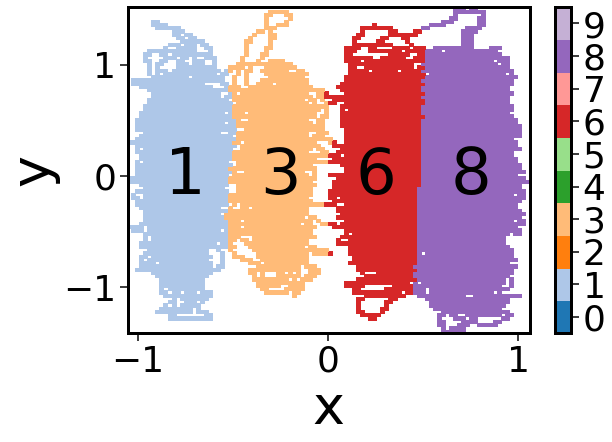

In [17]:
fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], label_map50.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

ax.text(-0.75,0,'1',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.75,0,'8',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(-0.25,0,'3',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.25,0,'6',horizontalalignment='center',verticalalignment='center',fontsize=64)

plt.xlabel("x")
plt.ylabel("y")

In [18]:
# plot the learned RC for four well potential system
data=traj_data

hist=plt.hist2d(data[:,0],data[:,1],bins=100)
hist_RC=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


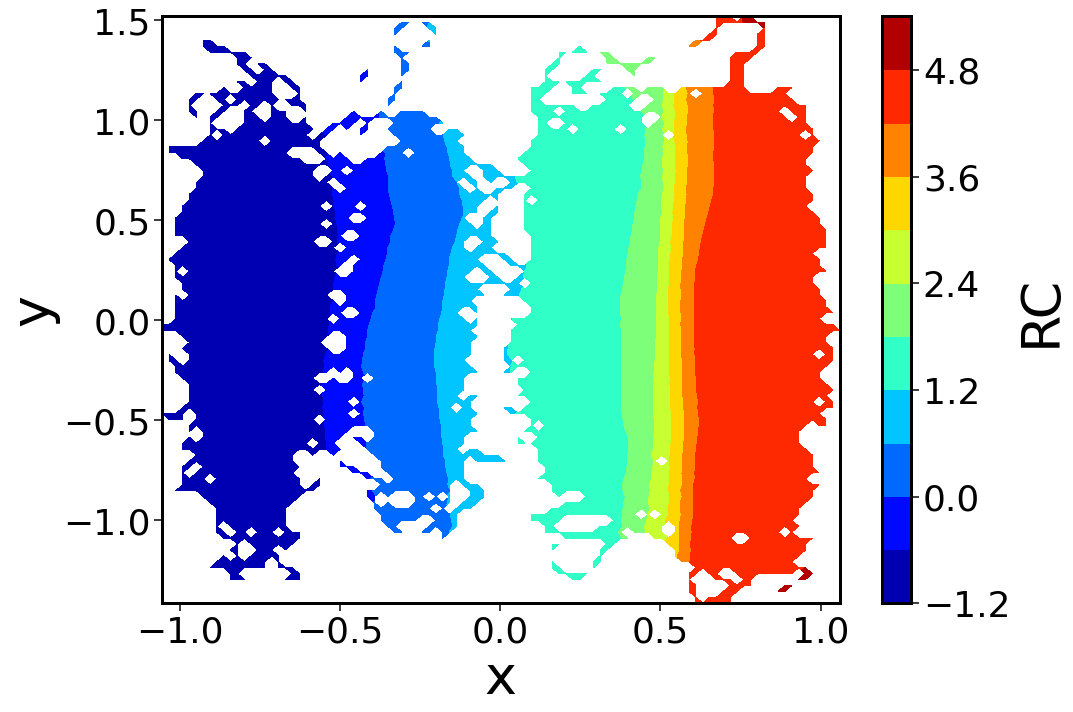

In [19]:
fig, ax = plt.subplots(figsize=(15,10))

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                    cmap=plt.cm.jet)
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC')

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()